# IF5100 Programming for Data Analytics | Tugas Besar

### Kelompok 9:
Clement Nathanael Lim / 18222032

Najmi I T Kertasafari / 23324005

Batrisyia Zahrani Ananto / 23525042

In [1]:
# Import library yang dibutuhkan

import pandas as pd
import numpy as np
import re
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from typing import Any


## Data Preparation

PhiUSIIL Phishing URL Dataset adalah dataset yang terdiri dari deskripsi suatu URL dan juga fitur-fitur yang terkait dengan URL tersebut beserta label URL legitimate dan URL phishing. Label 1 merupakan label untuk URL legitimate, sementara label 0 merupakan label untuk URL phishing.

Dataset ini memiliki banyak parameter / kolom yang cukup banyak sehingga menarik untuk dianalisis lebih lanjut, terutama untuk bagian feature engineeringnya. Selain itu, datasetnya juga cukup berkaitan dengan bidang IT yakni bagaimana kita bisa mendeteksi URL yang bersifat phising dari berbagai macam karakteristiknya.

Pada tahap ini, akan dilakukan pemrosesan data, dimulai dari melakukan EDA, Data Cleaning, Feature Engineering, Encoding, untuk menyiapkan data agar siap dimodelkan.

In [3]:
# Import dataset

df = pd.read_csv('PhiUSIIL_Phishing_URL_Dataset.csv')
df.head()

,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,...,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,...,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,...,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,...,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,...,1,0,1,244,15,34,72,1,85,1


In [4]:
# Membagi data 80 20, 80% training 20% validation sebelum data berubah

original_train_set = df.copy()

X = original_train_set.drop(columns=['label', 'URL', 'Domain', 'Title'])  # Fitur - fitur yang akan di - drop
y = original_train_set['label']  # Target/label

# Split data menjadi train_set dan val_set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Ukuran training set: {X_train.shape[0]}")
print(f"Ukuran validation set: {X_test.shape[0]}")


Ukuran training set: 165056
Ukuran validation set: 70739


### 1. Exploratory Data Analysis

In [5]:
# Melihat jumlah baris dan kolom dataset

print(f"Data terdiri atas {df.shape[0]} baris dan {df.shape[1]} kolom.")

# Dataset tersebut memiliki cukup banyak baris dan juga kolom (fitur), yang memungkinkan untuk dilakukan pembuatan model machine learning secara akurat.

Data terdiri atas 235795 baris dan 55 kolom.


In [6]:
## Melihat info dari dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 235795 entries, 0 to 235794
Data columns (total 55 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   URL                         235795 non-null  object 
 1   URLLength                   235795 non-null  int64  
 2   Domain                      235795 non-null  object 
 3   DomainLength                235795 non-null  int64  
 4   IsDomainIP                  235795 non-null  int64  
 5   TLD                         235795 non-null  object 
 6   URLSimilarityIndex          235795 non-null  float64
 7   CharContinuationRate        235795 non-null  float64
 8   TLDLegitimateProb           235795 non-null  float64
 9   URLCharProb                 235795 non-null  float64
 10  TLDLength                   235795 non-null  int64  
 11  NoOfSubDomain               235795 non-null  int64  
 12  HasObfuscation              235795 non-null  int64  
 13  NoOfObfuscated

In [7]:
# Melihat deskripsi dari masing - masing atribut.

df.describe()

,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,...,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
count,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,...,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000,235795.000000
mean,34.573095,21.470396,0.002706,78.430778,0.845508,0.260423,0.055747,2.764456,1.164758,0.002057,...,0.237007,0.023474,0.486775,26.075689,6.333111,10.522305,65.071113,2.377629,49.262516,0.571895
std,41.314153,9.150793,0.051946,28.976055,0.216632,0.251628,0.010587,0.599739,0.600969,0.045306,...,0.425247,0.151403,0.499826,79.411815,74.866296,22.312192,176.687539,17.641097,161.027430,0.494805
min,13.000000,4.000000,0.000000,0.155574,0.000000,0.000000,0.001083,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,16.000000,0.000000,57.024793,0.680000,0.005977,0.050747,2.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,27.000000,20.000000,0.000000,100.000000,1.000000,0.079963,0.057970,3.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,8.000000,2.000000,6.000000,12.000000,0.000000,10.000000,1.000000
75%,34.000000,24.000000,0.000000,100.000000,1.000000,0.522907,0.062875,3.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,29.000000,8.000000,15.000000,88.000000,1.000000,57.000000,1.000000
max,6097.000000,110.000000,1.000000,100.000000,1.000000,0.522907,0.090824,13.000000,10.000000,1.000000,...,1.000000,1.000000,1.000000,8956.000000,35820.000000,6957.000000,27397.000000,4887.000000,27516.000000,1.000000


In [7]:
# Mencari missing values

df.isnull().sum()

# Data tidak ada missing values

,0
URL,0
URLLength,0
Domain,0
DomainLength,0
IsDomainIP,0
TLD,0
URLSimilarityIndex,0
CharContinuationRate,0
TLDLegitimateProb,0
URLCharProb,0


In [ ]:
# Mencari apakah ada data N/A

df.isna().sum()

# Data tidak ada N/A

,0
URL,0
URLLength,0
Domain,0
DomainLength,0
IsDomainIP,0
TLD,0
URLSimilarityIndex,0
CharContinuationRate,0
TLDLegitimateProb,0
URLCharProb,0


In [ ]:
# Mencari data duplikat

df.duplicated().sum()

# Data tidak ada duplikat

np.int64(0)

In [8]:
# Mencari URL yang tidak dimulai dengan HTTPS / WWW / HTTP, dengan asumsi ini merupakan URL yang tidak standar
kondisi_bukan_https = ~df['URL'].str.startswith('https://')
kondisi_bukan_http = ~df['URL'].str.startswith('http://')
kondisi_bukan_www = ~df['URL'].str.startswith('www.')

url_tidak_standar = df[kondisi_bukan_https & kondisi_bukan_http & kondisi_bukan_www]

#Mengitung jumlah URL yang memenuhi kriteria
jumlah_url_tidak_standar = len(url_tidak_standar)

# Menampilkan hasil
print(f"URL yang tidak standar: {url_tidak_standar}")

print(f"\nJumlah total URL dengan format tidak standar: {jumlah_url_tidak_standar}")

URL yang tidak standar: Empty DataFrame
Columns: [URL, URLLength, Domain, DomainLength, IsDomainIP, TLD, URLSimilarityIndex, CharContinuationRate, TLDLegitimateProb, URLCharProb, TLDLength, NoOfSubDomain, HasObfuscation, NoOfObfuscatedChar, ObfuscationRatio, NoOfLettersInURL, LetterRatioInURL, NoOfDegitsInURL, DegitRatioInURL, NoOfEqualsInURL, NoOfQMarkInURL, NoOfAmpersandInURL, NoOfOtherSpecialCharsInURL, SpacialCharRatioInURL, IsHTTPS, LineOfCode, LargestLineLength, HasTitle, Title, DomainTitleMatchScore, URLTitleMatchScore, HasFavicon, Robots, IsResponsive, NoOfURLRedirect, NoOfSelfRedirect, HasDescription, NoOfPopup, NoOfiFrame, HasExternalFormSubmit, HasSocialNet, HasSubmitButton, HasHiddenFields, HasPasswordField, Bank, Pay, Crypto, HasCopyrightInfo, NoOfImage, NoOfCSS, NoOfJS, NoOfSelfRef, NoOfEmptyRef, NoOfExternalRef, label]
Index: []

[0 rows x 55 columns]

Jumlah total URL dengan format tidak standar: 0


In [9]:
# Mencari URL dengan karakter yang tidak sesuai

karakter_aneh = r"[^a-zA-Z0-9\-\._~:/?#\[\]@!$&'()*+,;=%]" # Mencari karakter diluar alfabet maupun simbol pada umumnya

def find_weird_chars(url):
    if isinstance(url, str):
        found_chars = re.findall(karakter_aneh, url)
        if found_chars:
            return list(set(found_chars))
    return []


df['WeirdCharsFound'] = df['URL'].apply(find_weird_chars)

df['HasWeirdChars'] = df['WeirdCharsFound'].apply(lambda x: len(x) > 0)

# Menampilkan hasil
suspicious_urls = df[df['HasWeirdChars']]
print(suspicious_urls[['URL', 'WeirdCharsFound']])

                                                      URL  \
127839  https://22017-5502.s3.webspace.re/privatkunden...   
158380  https://vinted.6545657.xyz/p5ci5kt9Ã¢â‚¬â€¹Ã¢â...   

              WeirdCharsFound  
127839     [¤, Å, Â, Ã, “, £]  
158380  [€, ¹, Ã, ¢, ‚, ¬, â]  


### 2. Data Cleaning

In [10]:
kondisi_ada_huruf_besar = (df['URL'] != df['URL'].str.lower()) & (df['URL'].notna())

url_dengan_huruf_besar = df[kondisi_ada_huruf_besar]

print(url_dengan_huruf_besar)

jumlah = len(url_dengan_huruf_besar)
print(f"\nJumlah URL yang mengandung huruf besar: {jumlah}")

                                                      URL  URLLength  \
127839  https://22017-5502.s3.webspace.re/privatkunden...        128   
158380  https://vinted.6545657.xyz/p5ci5kt9Ã¢â‚¬â€¹Ã¢â...         65   

                           Domain  DomainLength  IsDomainIP  TLD  \
127839  22017-5502.s3.webspace.re            25           0   re   
158380         vinted.6545657.xyz            18           0  xyz   

        URLSimilarityIndex  CharContinuationRate  TLDLegitimateProb  \
127839            7.650119              0.636364           0.000094   
158380           12.652169              1.000000           0.001750   

        URLCharProb  ...  HasCopyrightInfo  NoOfImage  NoOfCSS  NoOfJS  \
127839     0.048575  ...                 0          0        1       0   
158380     0.030235  ...                 0          0        0       0   

        NoOfSelfRef  NoOfEmptyRef  NoOfExternalRef  label  \
127839            2             0                0      0   
158380            0

In [12]:
# Lowercase semua URL
df['URL_cleaned'] = df['URL'].str.lower()

print(df[['URL', 'URL_cleaned']])

                                                      URL  \
0                        https://www.southbankmosaics.com   
1                                https://www.uni-mainz.de   
2                          https://www.voicefmradio.co.uk   
3                             https://www.sfnmjournal.com   
4                      https://www.rewildingargentina.org   
...                                                   ...   
235790                     https://www.skincareliving.com   
235791                      https://www.winchester.gov.uk   
235792                    https://www.nononsensedesign.be   
235793  https://patient-cell-40f5.updatedlogmylogin.wo...   
235794                 https://www.alternativefinland.com   

                                              URL_cleaned  
0                        https://www.southbankmosaics.com  
1                                https://www.uni-mainz.de  
2                          https://www.voicefmradio.co.uk  
3                          

In [13]:
# URL semuanya sudah huruf kecil

kondisi_ada_huruf_besar = (df['URL_cleaned'] != df['URL_cleaned'].str.lower()) & (df['URL'].notna())

url_dengan_huruf_besar = df[kondisi_ada_huruf_besar]

if url_dengan_huruf_besar.empty:
    print("Tidak ditemukan URL yang mengandung huruf besar.")
else:
    print(url_dengan_huruf_besar)

jumlah = len(url_dengan_huruf_besar)
print(f"\nJumlah URL yang mengandung huruf besar: {jumlah}")

Tidak ditemukan URL yang mengandung huruf besar.

Jumlah URL yang mengandung huruf besar: 0


### 3. Data Validation

In [15]:
# Validasi untuk mencari apakah URL yang diberikan itu sama dengan kolom URL Length

df['is_valid_url_length'] = df['URL_cleaned'].str.len() == df['URLLength']
print(df['is_valid_url_length'].value_counts())

print("\nBaris yang Tidak Sesuai URLLength-nya:")
print(df[~df['is_valid_url_length']][['URL', 'URLLength']])

is_valid_url_length
False    187151
True      48644
Name: count, dtype: int64

Baris yang Tidak Sesuai URLLength-nya:
                                                      URL  URLLength
0                        https://www.southbankmosaics.com         31
1                                https://www.uni-mainz.de         23
2                          https://www.voicefmradio.co.uk         29
3                             https://www.sfnmjournal.com         26
4                      https://www.rewildingargentina.org         33
...                                                   ...        ...
235790                     https://www.skincareliving.com         29
235791                      https://www.winchester.gov.uk         28
235792                    https://www.nononsensedesign.be         30
235793  https://patient-cell-40f5.updatedlogmylogin.wo...         55
235794                 https://www.alternativefinland.com         33

[187151 rows x 2 columns]


In [16]:
# Validasi apakah domain sudah ada di URL atau belum

df['is_valid_domain_in_url'] = [
    (domain in url) if isinstance(url, str) and isinstance(domain, str) else True
    for url, domain in zip(df['URL'], df['Domain'])
]

print(df['is_valid_domain_in_url'].value_counts())

print("\nBaris yang Gagal Validasi Domain in URL:")
print(df[~df['is_valid_domain_in_url']][['URL', 'Domain']])

is_valid_domain_in_url
True    235795
Name: count, dtype: int64

Baris yang Gagal Validasi Domain in URL:
Empty DataFrame
Columns: [URL, Domain]
Index: []


In [17]:
# Melakukan validasi domain apakah sesuai format

df['is_valid_domain_format'] = ~(
    df['Domain'].str.startswith('-', na=False) |
    df['Domain'].str.endswith('-', na=False)
)

print(df['is_valid_domain_format'].value_counts())

print("\nBaris yang Gagal Validasi Format Domain:")
print(df[~df['is_valid_domain_format']][['Domain']])

is_valid_domain_format
True    235795
Name: count, dtype: int64

Baris yang Gagal Validasi Format Domain:
Empty DataFrame
Columns: [Domain]
Index: []


In [18]:
# Validasi Domain IP dan TLD

# Konsistensi IsDomainIP
pola_ip = r"^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$" # Format alamat IP
is_actually_ip = df['Domain'].str.match(pola_ip, na=False).astype(int)
df['is_valid_ip_flag'] = (is_actually_ip == df['IsDomainIP'])

# Validasi TLD
tld_umum = {'com', 'org', 'net', 'gov', 'edu', 'uk', 'de', 'io', 'co', 'info', 'xyz'}
df['is_valid_tld'] = (~df['TLD'].str.contains('\d', na=True, regex=True)) & \
                               (df['TLD'].isin(tld_umum))

print(df['is_valid_ip_flag'].value_counts())
print(df['is_valid_tld'].value_counts())

print("\nBaris yang Gagal Validasi IsDomainIP atau TLD:")
print(df[~(df['is_valid_ip_flag'] & df['is_valid_tld'])][['Domain', 'TLD', 'IsDomainIP']])

<>:10: SyntaxWarning: invalid escape sequence '\d'
<>:10: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipython-input-3784567409.py:10: SyntaxWarning: invalid escape sequence '\d'
  df['is_valid_tld'] = (~df['TLD'].str.contains('\d', na=True, regex=True)) & \


is_valid_ip_flag
True     235756
False        39
Name: count, dtype: int64
is_valid_tld
True     164634
False     71161
Name: count, dtype: int64

Baris yang Gagal Validasi IsDomainIP atau TLD:
                                                 Domain  TLD  IsDomainIP
8                                www.hyderabadonline.in   in           0
16                                        www.motley.ie   ie           0
17                                       www.funzine.hu   hu           0
19                                      www.ooty.ind.in   in           0
20                                 www.f0519141.xsph.ru   ru           0
...                                                 ...  ...         ...
235778                  www.ekel-nat.ekinsrr.lnedxt.top  top           0
235780             ww.prestamo.enlinea.pe.vpphoangha.vn   vn           0
235782               goldenrod-motley-texture.glitch.me   me           0
235792                          www.nononsensedesign.be   be           0
235

Dapat diketahui bahwa sebagian besar dataset sudah tervalidasi baik dari URL maupun dari IP address, walaupun masih terdapat sedikit kejanggalan pada data dengan URL yang tidak valid dengan kolom length URL yang ada.

### 4. Data Integration

In [19]:
# Menjumlahkan kolom - kolom yang menunjukkan aktivitas mencurigakan

content_suspicion_features = [
    'NoOfPopup',
    'NoOfiFrame',
    'HasExternalFormSubmit',
    'HasHiddenFields',
    'HasPasswordField',
    'NoOfSelfRedirect'
]
df['feature_content_suspicion_score'] = df[content_suspicion_features].sum(axis=1)

In [20]:
# Menjumlahkan data yang berhubungan dengan finansial

df['feature_financial_keyword_score'] = df[['Bank', 'Pay', 'Crypto']].sum(axis=1)

In [21]:
# Fitur untuk mengecek apakah suatu web cenderung mengarah ke aset di dirinya sendiri atau tidak
# Halaman phishing sederhana mungkin memiliki sedikit atau bahkan tidak ada referensi ke diri sendiri

denominator = df['NoOfExternalRef'] + df['NoOfSelfRef'] + 1
df['feature_self_ref_ratio'] = df['NoOfSelfRef'] / denominator

In [22]:
# Rasio link kosong

total_refs = df['NoOfEmptyRef'] + df['NoOfSelfRef'] + df['NoOfExternalRef'] + 1
df['feature_empty_ref_ratio'] = df['NoOfEmptyRef'] / total_refs

In [23]:
# Integrasi web yang tidak menggunakan protokol HTTPS dan tapi memiliki password

df['feature_insecure_password_field'] = ((df['IsHTTPS'] == 0) & (df['HasPasswordField'] == 1)).astype(int)

In [24]:
# Tanda jika skor kecocokan rendah tapi halaman ada keyword finansialnya, yang bisa mengarahkan ke penipuan

df['feature_mismatched_financial_page'] = ((df['DomainTitleMatchScore'] < 0.5) & (df['feature_financial_keyword_score'] > 0)).astype(int)

### 5. Feature Encoding

In [25]:
# Feature encoding untuk fitur kategorikal

class FeatureEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

    def fit(self, X, y=None):
        self.encoder.fit(X)
        return self

    def transform(self, X):
        return self.encoder.transform(X)


### 6. Feature Engineering

In [26]:
# FeatureSelector class untuk seleksi fitur
class FeatureSelector:
    def __init__(self, numerical_corr_threshold=0.2, categorical_cramers_v_threshold=0.2):
        self.numerical_corr_threshold = numerical_corr_threshold
        self.categorical_cramers_v_threshold = categorical_cramers_v_threshold
        self.selected_features = []

    def fit(self, X, y):
        # Seleksi fitur numerik berdasarkan korelasi dengan target
        numerical_features = [col for col in numerical_columns if col in X.columns]
        numerical_corr = X[numerical_features].corrwith(y).abs()
        selected_numerical = numerical_corr[numerical_corr >= self.numerical_corr_threshold].index.tolist()

        # Seleksi fitur kategorikal berdasarkan Cramer's V dengan target
        categorical_features = [col for col in categorical_columns if col in X.columns]
        selected_categorical = [
            col for col in categorical_features
            if self._calculate_cramers_v(X[col], y) >= self.categorical_cramers_v_threshold
        ]

        # Gabungkan fitur numerik dan kategorikal terpilih
        self.selected_features = selected_numerical + selected_categorical

        # Jika fitur yang terpilih lebih dari 7, pilih yang paling penting berdasarkan skor seleksi
        if len(self.selected_features) > 7:
            top_numerical = numerical_corr[numerical_corr.index.isin(selected_numerical)].nlargest(10).index.tolist()
            top_categorical = selected_categorical[:5]
            self.selected_features = top_numerical + top_categorical

        return self

    def _calculate_cramers_v(self, x, y):
        contingency_table = pd.crosstab(x, y)
        chi2, _, _, _ = chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()
        r, k = contingency_table.shape
        return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [27]:
# FeatureScaler class untuk scaling fitur

class FeatureScaler(BaseEstimator, TransformerMixin):
    def __init__(self, scaling_method='standardization'):
        self.scaling_method = scaling_method

    def fit(self, X, y=None):
        if self.scaling_method == 'minmax':
            self.scaler_ = MinMaxScaler()
        elif self.scaling_method == 'standardization':
            self.scaler_ = StandardScaler()
        elif self.scaling_method == 'robust':
            self.scaler_ = RobustScaler()
        else:
            raise ValueError(f"Scaling method {self.scaling_method} tidak dikenali.")

        self.scaler_.fit(X)
        return self

    def transform(self, X):
        return self.scaler_.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features


### 7. Inferencing

In [28]:
#KAMUS
numerical_columns = ['URLLength', 'DomainLength', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength',
                      'NoOfSubDomain', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL',
                      'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL',
                      'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'LineOfCode', 'LargestLineLength',
                      'DomainTitleMatchScore', 'URLTitleMatchScore', 'NoOfPopup', 'NoOfiFrame', 'NoOfImage', 'NoOfCSS',
                      'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef']
categorical_columns = [ 'TLD', 'Domain', 'IsResponsive', 'Robots', 'NoOfURLRedirect', 'HasHiddenFields', 'HasPasswordField',
                       'Pay', 'URL', 'HasSubmitButton', 'Title', 'Crypto', 'HasObfuscation', 'Bank', 'NoOfSelfRedirect',
                        'HasExternalFormSubmit', 'IsHTTPS', 'HasCopyrightInfo', 'HasTitle', 'FILENAME', 'HasSocialNet',
                        'HasFavicon', 'HasDescription', 'IsDomainIP']
# Identifikasi kolom biner
binary_columns = [
    "IsDomainIP", "HasObfuscation", "IsHTTPS", "HasTitle",
    "HasFavicon", "Robots", "IsResponsive", "HasDescription", "NoOfURLRedirect", "NoOfSelfRedirect",
    "HasExternalFormSubmit", "HasSocialNet", "HasSubmitButton",
    "HasHiddenFields", "HasPasswordField", "Bank", "Pay",
    "Crypto", "HasCopyrightInfo",
]

# Identifikasi kolom kategorikal non-biner
non_binary_columns = [col for col in categorical_columns if col not in binary_columns]


In [29]:
# Tentukan kolom numerik dan kategorikal
numerical_columns = [col for col in X_train.columns if pd.api.types.is_numeric_dtype(X_train[col])]
categorical_columns = [col for col in X_train.columns if X_train[col].dtype == 'object']

# 1. Inisialisasi dan fit feature selector
selector = FeatureSelector(numerical_corr_threshold=0.2, categorical_cramers_v_threshold=0.3)
selector.fit(X, y)

# 2. Menampilkan 10 fitur terbaik yang terpilih
print("Fitur terpilih: ", selector.selected_features)

Fitur terpilih:  ['URLSimilarityIndex', 'HasSocialNet', 'HasCopyrightInfo', 'HasDescription', 'IsHTTPS', 'DomainTitleMatchScore', 'HasSubmitButton', 'IsResponsive', 'URLTitleMatchScore', 'SpacialCharRatioInURL', 'TLD']


In [30]:
#Fitur yang dipilih
# URL Similarity index dihapus karena pada dasarnya hanya untuk filter awal saja dan dapat membuat model overfit, sehingga diabaikan
num2_columns = ['DomainTitleMatchScore', 'URLTitleMatchScore', 'SpacialCharRatioInURL']
cat2_columns = ['HasSocialNet', 'HasCopyrightInfo', 'HasDescription', 'IsHTTPS', 'HasSubmitButton', 'IsResponsive', 'TLD']


In [31]:

# 1. Definisikan ColumnTransformer untuk menangani preprocessing numerik dan kategorikal
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler',StandardScaler())  # Normalisasi fitur numerik
        ]), num2_columns),

        ('cat', Pipeline([
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), cat2_columns)
    ])

# 2. Buat pipeline untuk preprocessing
pipeline = Pipeline([
    ('preprocessor', preprocessor)
])

# 3. Fit pipeline pada data pelatihan (X_train)
pipeline.fit(X_train)

# 4. Transformasi data pelatihan
X_train_transformed = pipeline.transform(X_train)

# Pastikan data pelatihan berupa DataFrame dengan nama kolom yang sesuai
X_train_transformed = pd.DataFrame(X_train_transformed, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())


# 6. Transformasi data validasi
X_test_transformed = pipeline.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=pipeline.named_steps['preprocessor'].get_feature_names_out())


# Pastikan semua kolom dalam X_val_transformed adalah numerik
X_test_transformed = X_test_transformed.apply(pd.to_numeric, errors='coerce')


In [32]:
# Model k-NN dengan scikit-learn

class KNNWithScikitLearn:
    def __init__(self, n_neighbors, metric='euclidean', p=3):
        self.n_neighbors = n_neighbors
        self.metric = metric
        self.p = p
        self.model = None

    def fit(self, X_train, y_train):
        self.model = KNeighborsClassifier(n_neighbors=self.n_neighbors, metric=self.metric, p=self.p)
        self.model.fit(X_train, y_train)

    def predict(self, X_test):
        return self.model.predict(X_test)

    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        return accuracy_score(y_test, y_pred)

def test_knn(X_train, X_test, y_train, y_test, n_neighbors=5):
    metrics = ['euclidean']
    accuracies = {}

    for metric in metrics:
        knn = KNNWithScikitLearn(n_neighbors=n_neighbors, metric=metric)
        knn.fit(X_train, y_train)
        accuracy = knn.score(X_test, y_test)
        accuracies[metric] = accuracy
        print(f'Akurasi dengan {metric} distance: {accuracy}')

    return accuracies

In [33]:
# Menjalankan KNN dengan metrik euclidean distance

X_train_transformed_np = X_train_transformed.to_numpy() if hasattr(X_train_transformed, 'to_numpy') else X_train_transformed
X_test_transformed_np = X_test_transformed.to_numpy() if hasattr(X_test_transformed, 'to_numpy') else X_test_transformed

acuracies = test_knn(X_train_transformed_np, X_test_transformed_np, y_train, y_test, n_neighbors=200)
# KNN dengan metrik euclidean distance
knn = KNNWithScikitLearn(n_neighbors=200, metric='euclidean')
knn.fit(X_train_transformed, y_train)
y_test_pred_euclidean = knn.predict(X_test_transformed)

print("Classification Report Euclidean: ")
print(classification_report(y_test, y_test_pred_euclidean))

print("F1 Score Euclidean: ", f1_score(y_test, y_test_pred_euclidean, average='macro'))

Akurasi dengan euclidean distance: 0.9877436774622202
Classification Report Euclidean: 
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     30284
           1       0.99      0.99      0.99     40455

    accuracy                           0.99     70739
   macro avg       0.99      0.99      0.99     70739
weighted avg       0.99      0.99      0.99     70739

F1 Score Euclidean:  0.9874928337936804


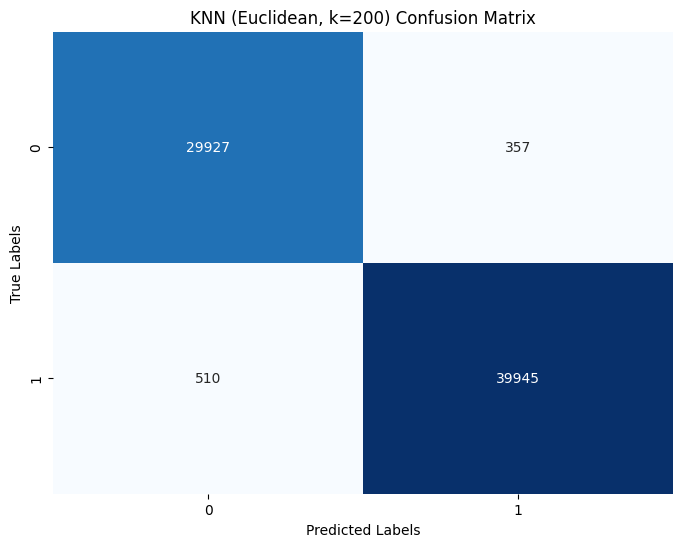

In [34]:
# Confusion Matrix untuk KNN
cm_knn = confusion_matrix(y_test, y_test_pred_euclidean)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('KNN (Euclidean, k=200) Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [35]:
# Model random forest

rf_dasar = RandomForestClassifier(random_state=42, n_jobs=-1)

rf_dasar.fit(X_train_transformed, y_train)
accuracy_dasar = rf_dasar.score(X_test_transformed, y_test)
print(f'Akurasi Model Dasar Random Forest: {accuracy_dasar}')
y_pred_dasar = rf_dasar.predict(X_test_transformed)
print("\nLaporan Klasifikasi untuk Model Dasar:")
print(classification_report(y_test, y_pred_dasar))
print(f'F1 Score Macro: {f1_score(y_test, y_pred_dasar, average="macro")}')

Akurasi Model Dasar Random Forest: 0.9932993115537398

Laporan Klasifikasi untuk Model Dasar:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     30284
           1       0.99      1.00      0.99     40455

    accuracy                           0.99     70739
   macro avg       0.99      0.99      0.99     70739
weighted avg       0.99      0.99      0.99     70739

F1 Score Macro: 0.9931553510335549


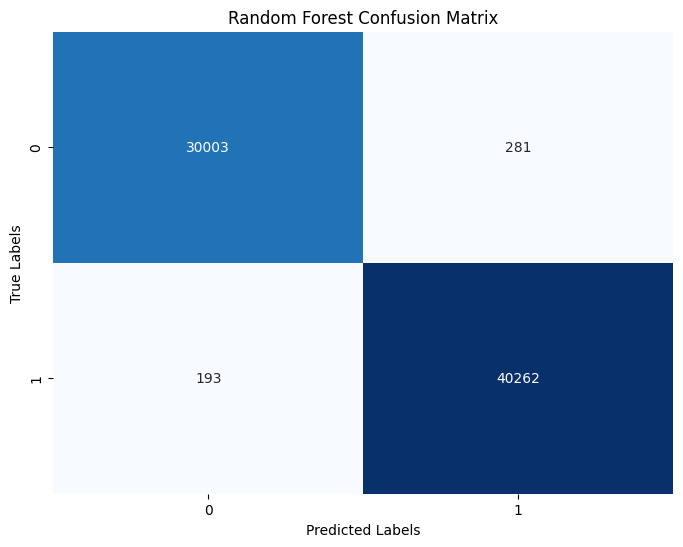

In [36]:
# Confusion Matrix untuk Random Forest
cm_rf = confusion_matrix(y_test, y_pred_dasar)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, cmap='Blues', fmt='d', cbar=False)
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


--- Feature Importance dari Model Random Forest ---
                  feature  importance
6      HasCopyrightInfo_1    0.100294
5      HasCopyrightInfo_0    0.096029
3          HasSocialNet_0    0.092460
4          HasSocialNet_1    0.091180
8        HasDescription_1    0.078560
10              IsHTTPS_1    0.061637
2   SpacialCharRatioInURL    0.060713
0   DomainTitleMatchScore    0.058607
9               IsHTTPS_0    0.057784
7        HasDescription_0    0.056564
1      URLTitleMatchScore    0.045495
12      HasSubmitButton_1    0.042631
14         IsResponsive_1    0.035018
11      HasSubmitButton_0    0.032825
13         IsResponsive_0    0.028123

Visualisasi 15 Fitur Paling Penting:


/tmp/ipython-input-2915664961.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=df_importances.head(15), palette='viridis')


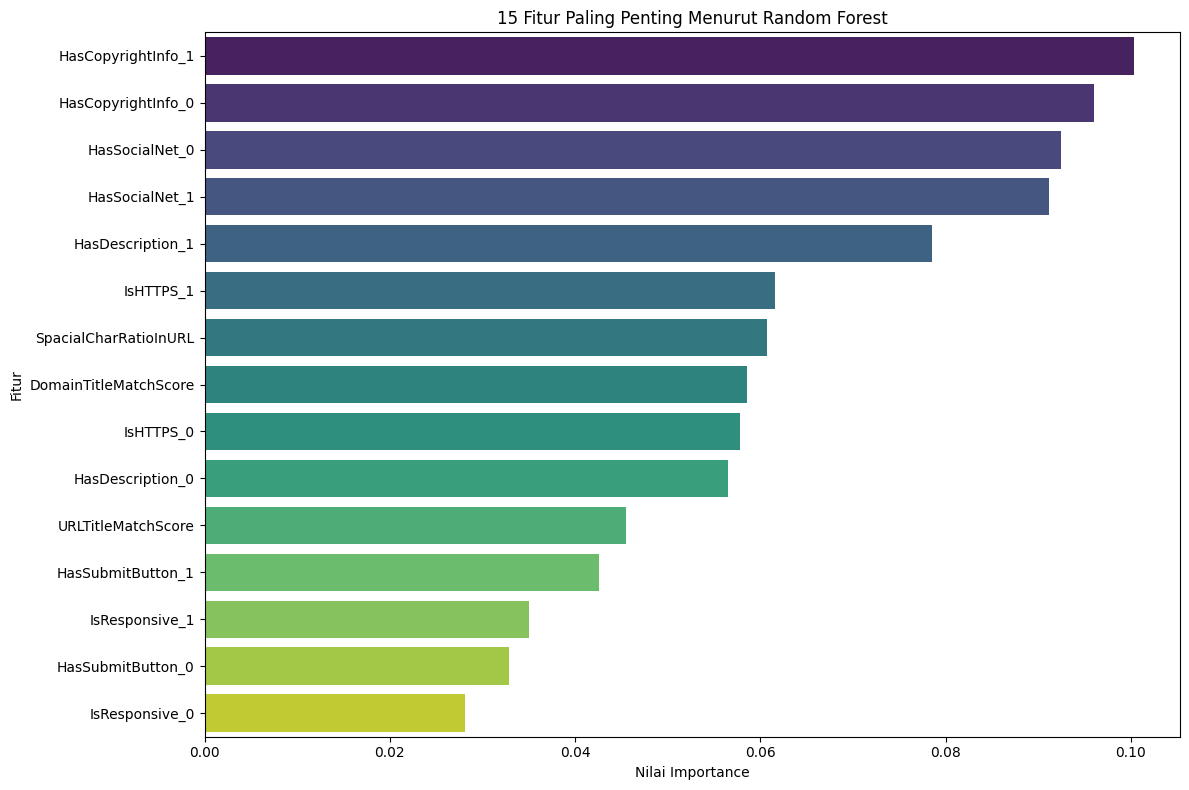

In [37]:
# Feature importance dari model random forest
importances = rf_dasar.feature_importances_

try:
    # Mengambil nama fitur dari transformer 'cat' (OneHotEncoder)
    encoded_cat_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat2_columns)
    feature_names = list(num2_columns) + list(encoded_cat_names)

except Exception as e:
    print(f"Error mendapatkan nama fitur: {e}")
    feature_names = list(num2_columns) + list(preprocessor.named_transformers_['cat'].get_feature_names(cat2_columns))


# Menggabungkan Nama Fitur dengan Nilai Importance
df_importances = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)


# Menampilkan 15 fitur paling penting

print("--- Feature Importance dari Model Random Forest ---")
print(df_importances.head(15))

print("\nVisualisasi 15 Fitur Paling Penting:")
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=df_importances.head(15), palette='viridis')
plt.title('15 Fitur Paling Penting Menurut Random Forest')
plt.xlabel('Nilai Importance')
plt.ylabel('Fitur')
plt.tight_layout()
plt.show()

In [38]:
# Save model

class SaveModelLoader:
    def save(model, filename):
        filepath = "pkl/" + filename
        try:
            with open(filepath, 'wb') as file:
                pickle.dump(model, file)
            print(f"Model berhasil disimpan di {filepath}")
        except Exception as e:
            print(f"Error menyimpan model ke {filepath}: {e}")
    def load(filename: str) -> Any:
        filepath = "pkl/" + filename
        try:
            with open(filepath, 'rb') as file:
                model = pickle.load(file)
            print(f"Model berhasil di load dari {filepath}")
            return model
        except FileNotFoundError:
            print(f"Error: File {filepath} not found.")
        except Exception as e:
            print(f"Error loading model dari {filepath}: {e}")


## Data Visualization

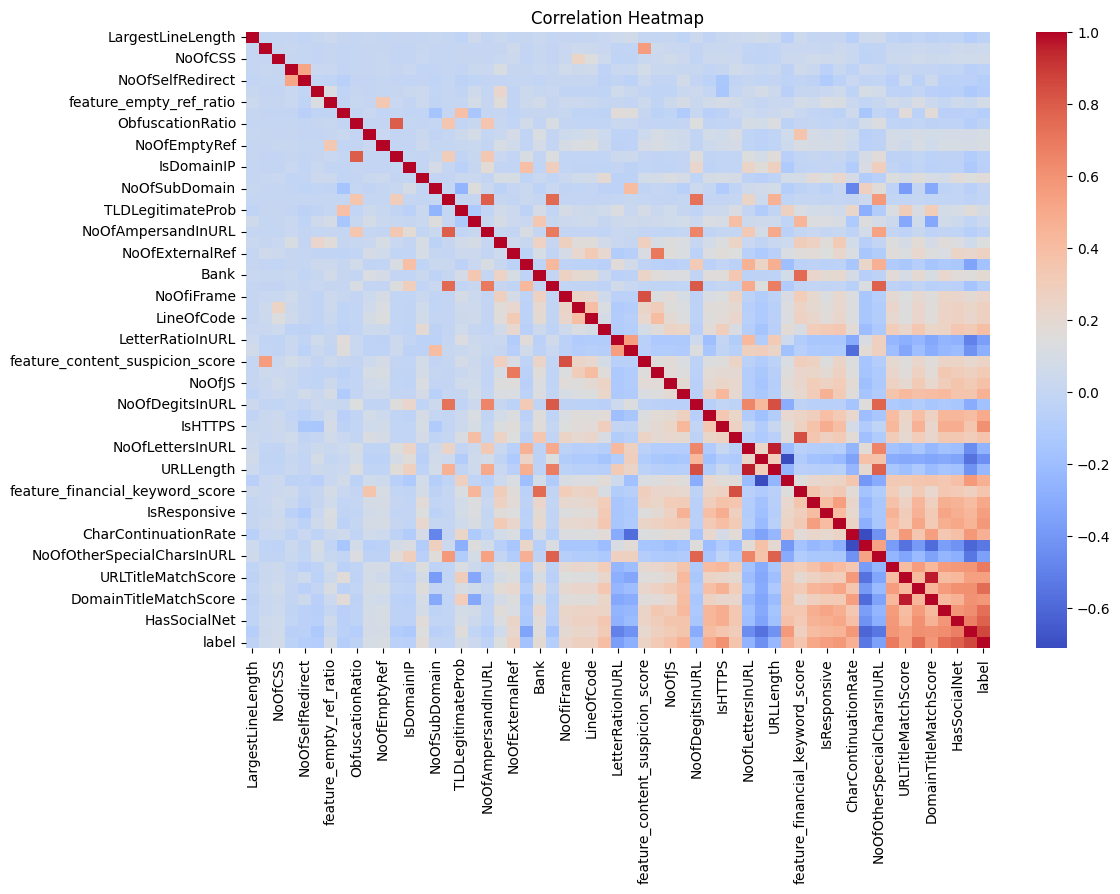

In [39]:
# Heatmap with sorted correlation (from lowest to highest)
num_df = df.select_dtypes(include=['int64', 'float64'])

# Hitung korelasi
corr = num_df.corr()

# Urutkan berdasarkan nilai korelasi total (mean absolute correlation)
sorted_cols = corr.abs().mean().sort_values().index

# Reorder baris dan kolom
corr_sorted = corr.loc[sorted_cols, sorted_cols]

plt.figure(figsize=(12, 8))
sns.heatmap(corr_sorted, annot=False, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


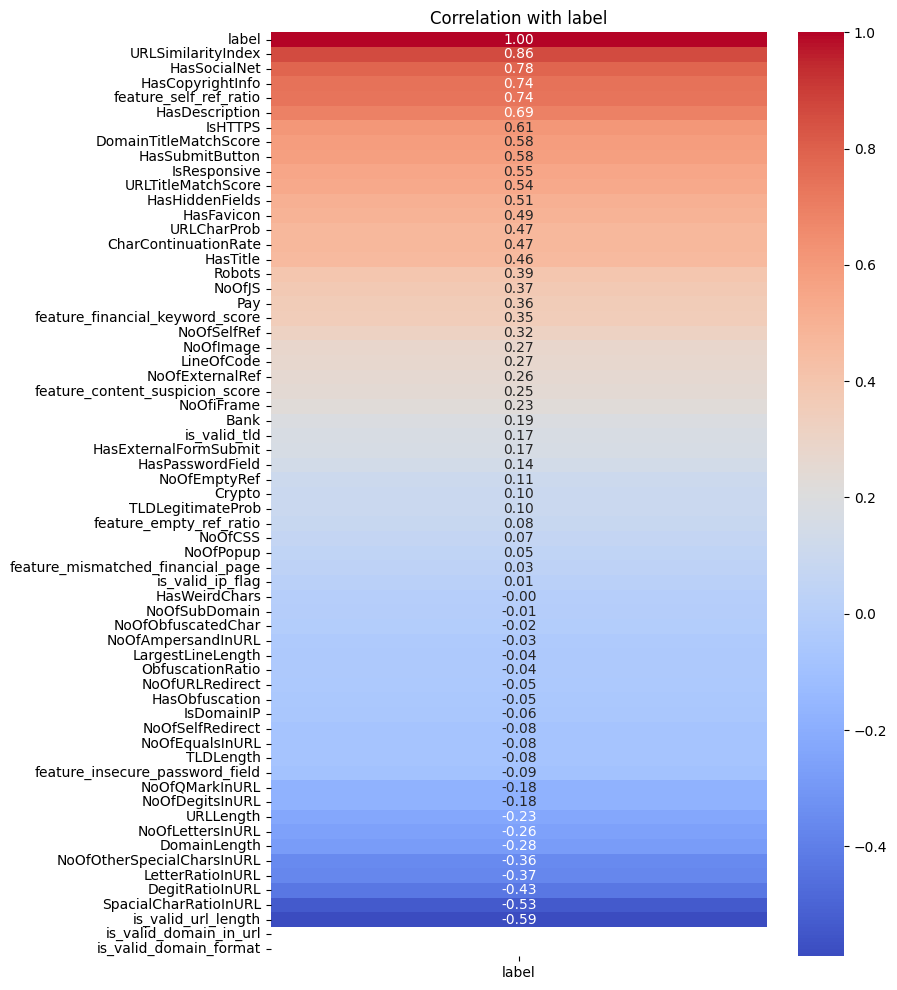

In [40]:

# Hitung korelasi matriks 'label' terhadap fitur-fitur numerik
correlation_matrix = df.corr(numeric_only=True)
quality_correlation = correlation_matrix['label'].sort_values(ascending=False)

plt.figure(figsize=(8, 12))
sns.heatmap(quality_correlation.to_frame(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation with label')
plt.show()

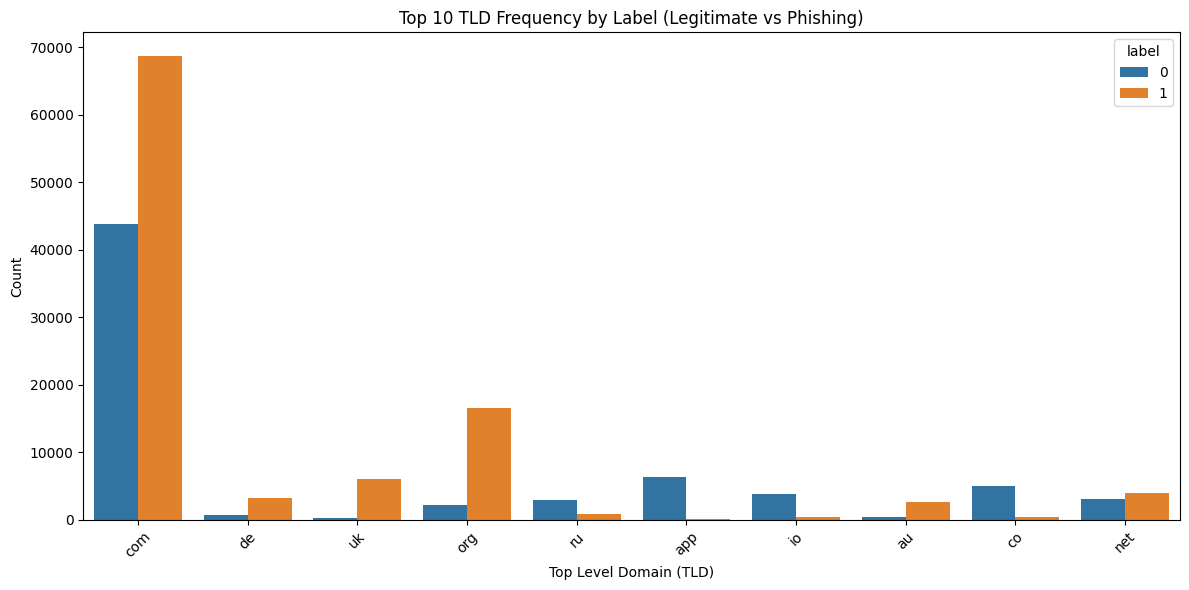

In [41]:
#TLD Frequency Plot

top10_tlds = df['TLD'].value_counts().head(10).index

df_top10 = df[df['TLD'].isin(top10_tlds)]

plt.figure(figsize=(12, 6))
sns.countplot(data=df_top10, x="TLD", hue="label")
plt.xticks(rotation=45)
plt.title("Top 10 TLD Frequency by Label (Legitimate vs Phishing)")
plt.xlabel("Top Level Domain (TLD)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



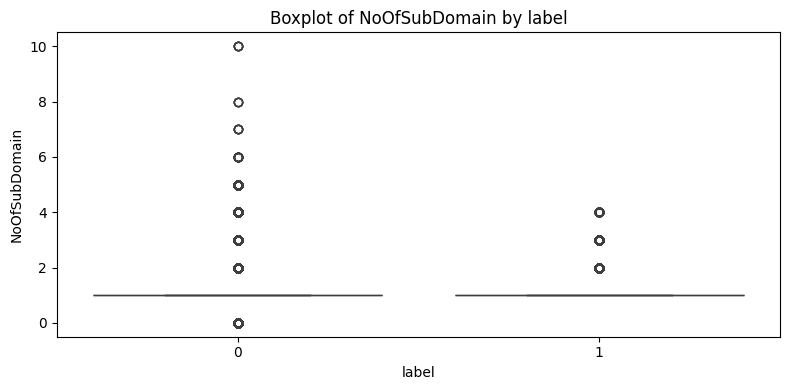

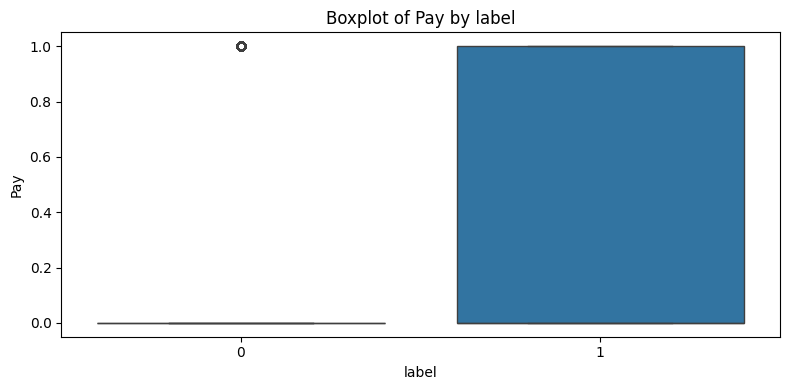

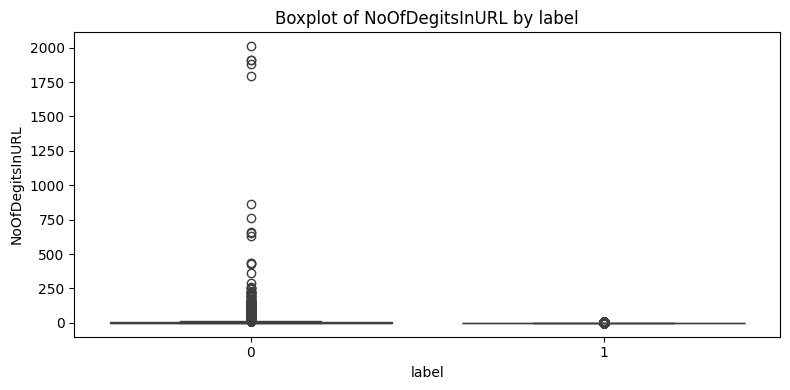

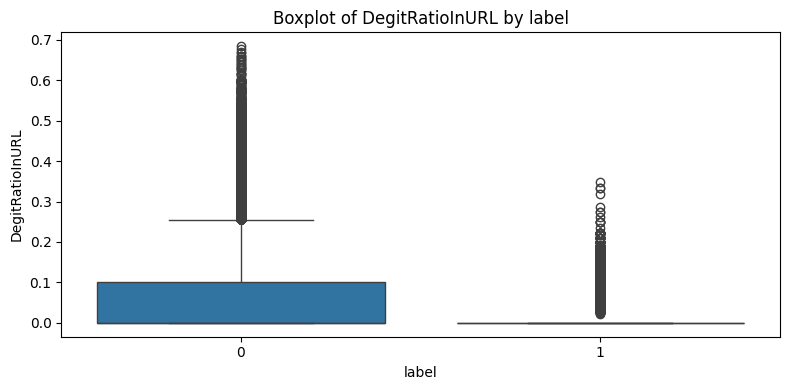

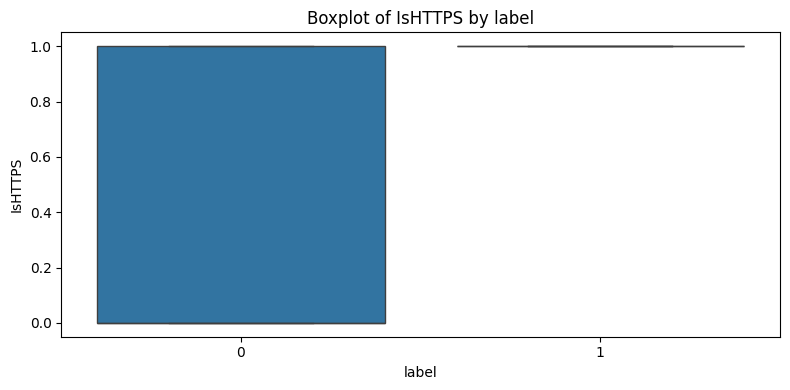

In [42]:
#Boxplot

top5_outliers = ['NoOfSubDomain', 'Pay', 'NoOfDegitsInURL',
                 'DegitRatioInURL', 'IsHTTPS']
label_col = "label"

for col in top5_outliers:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=df, x=label_col, y=col)
    plt.title(f"Boxplot of {col} by {label_col}")
    plt.tight_layout()
    plt.show()